In [1]:
import random
import numpy as np
import pandas as pd
import tqdm       
import copy
import itertools 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import ParameterGrid

# Unsupervised Learning models / Clustering
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Unsupervised Learning models / Clustering metrics
from sklearn.metrics import silhouette_score
from sklearn import metrics

# NLP
import tensorflow as tf
import nltk 
from string import punctuation
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # BoW, TFIDF
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import WordPunctTokenizer, PunktSentenceTokenizer
from keras.preprocessing.text import Tokenizer # Ovoj Tokenizer gi pretvara direktno vo unikatni broevi
from keras.utils import pad_sequences
eng_stopwords = stopwords.words("english")
import gensim.downloader as gen_downloader

from scipy.spatial.distance import cosine # cosine similarity
from unidecode import unidecode           # returns unicode characters (unicode transliteration)

#from keras.utils import np_utils          # one hot encoding vo VS Code
from keras.utils import to_categorical     # one hot encoding vo Colab

RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

#
---
# FIRST DATASET: 'ingredient_w_synonyms.csv'

Cleaning the dataset

In [2]:
# org_df = pd.read_csv('ingredient_w_synonyms.csv', sep=';')
# df = org_df.copy()

# display(df)

In [3]:
# duplicates_name = df[df['name'].duplicated()]
# duplicates_synonym = df[df['synonym'].duplicated()]
# display(duplicates_name)
# display(duplicates_synonym)


In [4]:
# df[df['name'].duplicated()]

In [5]:
# df = df.drop_duplicates(subset='name')
# df


In [6]:
# df.to_csv('ingredient_w_synonyms_clean.csv')

Importing clean dataset for further test preprocessing

In [7]:
org_df = pd.read_csv('ingredient_w_synonyms_clean.csv')
df = org_df.copy()

display(df)

,Unnamed: 0,name,synonym
0,0,Niacinamide,"Vitamin B3, Nicotinamide, and 3-Pyridinecarbox..."
1,1,Hyaluronic Acid,Hyaluronan
2,2,Salicylic Acid,NaN
3,3,Glycerin,"Vegetable Glycerin, Glycerine, and Glycerol"
4,4,Retinol,Vitamin A
...,...,...,...
27635,27638,Dibutyldecyl Ipdi,NaN
27636,27639,Capsella Bursa-Pastoris Sprout Water,NaN
27637,27640,Carboxyethyl Acrylate,NaN
27638,27641,Candelilla Wax Hydrocarbons,NaN


In [8]:
df = df.drop(columns='Unnamed: 0')

In [9]:
df['all_possible_synonyms'] = df['name'] + ', ' + df['synonym']
df['all_possible_synonyms'].fillna(df['name'], inplace=True)
df

,name,synonym,all_possible_synonyms
0,Niacinamide,"Vitamin B3, Nicotinamide, and 3-Pyridinecarbox...","Niacinamide, Vitamin B3, Nicotinamide, and 3-P..."
1,Hyaluronic Acid,Hyaluronan,"Hyaluronic Acid, Hyaluronan"
2,Salicylic Acid,NaN,Salicylic Acid
3,Glycerin,"Vegetable Glycerin, Glycerine, and Glycerol","Glycerin, Vegetable Glycerin, Glycerine, and G..."
4,Retinol,Vitamin A,"Retinol, Vitamin A"
...,...,...,...
27635,Dibutyldecyl Ipdi,NaN,Dibutyldecyl Ipdi
27636,Capsella Bursa-Pastoris Sprout Water,NaN,Capsella Bursa-Pastoris Sprout Water
27637,Carboxyethyl Acrylate,NaN,Carboxyethyl Acrylate
27638,Candelilla Wax Hydrocarbons,NaN,Candelilla Wax Hydrocarbons


In [10]:
def is_sent_ok(toks: list, threshold: int) -> bool:
    if len(toks) >= threshold:
        return True
    return False

def clean_text(s):
    # Check if s is a string
    if isinstance(s, str):
        s = unidecode(s)  # è -> e (unicode transliteration)
        s = s.lower()

        #DA SE TRGNI STOPWORD end???? no problematicno e so se srekjava do zapirka ili pa voopsto nema zapirka, taka da ako se izbrisi moze dvata zbora da se spojat ako nema zapirka

        # s = s.translate(str.maketrans('', '', punctuation))
        # s = WordPunctTokenizer().tokenize(s)
        # s = [el for el in s if el not in eng_stopwords]  # Make sure 'eng_stopwords' is defined in your code
        return s
    else:
        return s  # Return the input unchanged if it's not a string
    
    if is_sent_ok(s, 1):
        return " ".join(s)
    return np.nan

Nekoi zabeleski za datasetot:
- Ne treba da se odzemaat stopwords, zatoa sto gi menuva primer Vitamin A, go krati na Vitamin
- Ne treba lematizacija, zatoa sto vekje se lematizirani!??
- Punktuacijata isto taka mislam deka e bitna I treba da ostani, imame soedinenija koi vo imeto imaat zapirka I crticka
- Imame brojki, niv ne treba da gi dekodirame, se buni funkcijata..
- Edinstven stopword sto ne ni treba e “and” vo listata so sinonimi gi nabrojuva oddeleni so zapirka I posledniot e so and dodaden (problematicno e sto se srekjava do zapirka ili pa voopsto nema zapirka, taka da ako se izbrisi moze dvata zbora da se spojat ako nema zapirka)
- Ima lista so 540 sostojki sto se so brojki, crtki, zapirki, edinstveno pozitivno e sto se unique vo NASIOT dataset, t.e. samo dve od niv imaat sinonim


In [11]:
df = df.copy()
df['all_possible_synonyms_tok'] = df['all_possible_synonyms'].apply(clean_text)

Deleting all the rows from the dataset, that have long list of names in brackets:

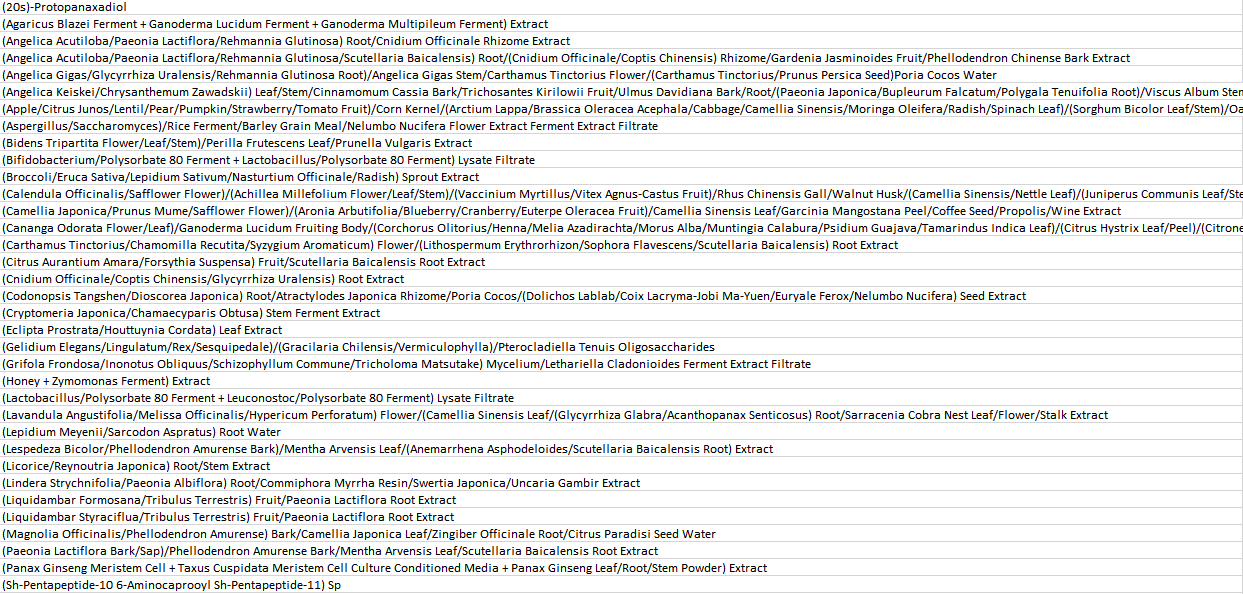

In [12]:
df = df[~df['name'].str.startswith('(')]
df = df[~df['name'].str.startswith('[')]
df

,name,synonym,all_possible_synonyms,all_possible_synonyms_tok
0,Niacinamide,"Vitamin B3, Nicotinamide, and 3-Pyridinecarbox...","Niacinamide, Vitamin B3, Nicotinamide, and 3-P...","niacinamide, vitamin b3, nicotinamide, and 3-p..."
1,Hyaluronic Acid,Hyaluronan,"Hyaluronic Acid, Hyaluronan","hyaluronic acid, hyaluronan"
2,Salicylic Acid,NaN,Salicylic Acid,salicylic acid
3,Glycerin,"Vegetable Glycerin, Glycerine, and Glycerol","Glycerin, Vegetable Glycerin, Glycerine, and G...","glycerin, vegetable glycerin, glycerine, and g..."
4,Retinol,Vitamin A,"Retinol, Vitamin A","retinol, vitamin a"
...,...,...,...,...
27635,Dibutyldecyl Ipdi,NaN,Dibutyldecyl Ipdi,dibutyldecyl ipdi
27636,Capsella Bursa-Pastoris Sprout Water,NaN,Capsella Bursa-Pastoris Sprout Water,capsella bursa-pastoris sprout water
27637,Carboxyethyl Acrylate,NaN,Carboxyethyl Acrylate,carboxyethyl acrylate
27638,Candelilla Wax Hydrocarbons,NaN,Candelilla Wax Hydrocarbons,candelilla wax hydrocarbons


#
---
# SECOND DATASET '_Product__RAW_Data.xlsx'

In [13]:
org_df_barcode = pd.read_excel('_Product__RAW_Data.xlsx')
df_barcode = org_df_barcode.copy()

display(df_barcode)

,Barcode,Unnamed: 1,Ingredient List,Name
0,3600542399326,3600542399326,"Aqua / Water, Aluminum Chlorohydrate, Cetearyl...",Garnier Mineral Hyaluronic Care 72H Deodorant ...
1,8606029266766,8606029266766,Silicone,Velnea Fingering Silik.Lila
2,4049639429550,4049639429550,"aqua (water),stearic acid,copernicia cerifera ...","Magic Finish 5-In-1 Hybrid Mascara\nVolume, Le..."
3,4011700740291,4011700740291,"butane,alcohol,propane,parfum (fragrance),dipr...",Echt Kï¿½Lnisch Wasser Aerosol Deodorant Spray...
4,4011700740475,4011700740475,"sodium palmate,sodium palm kernelate,aqua (wat...",Echt Kï¿½Lnisch Wasser Cream Soap\nMildly Clea...
...,...,...,...,...
13669,8034063521822,8034063521822,"Aqua [Water], Sodium coco-sulfate, Cocamidopro...",Shampoo Leaves Strengthening Anti-Age With Gin...
13670,6001051004959,6001051004959,"Aqua, Alcohol Denat., Butyl Methoxydibenzoylme...",Sun Babies & Kids Kids' Sun Spray Spf 50+
13671,5060447940494,5060447940494,"Aqua (Water), Octocrylene, Alcohol Denat., Gly...",Sun Cream Spf 30
13672,4005900870407,4005900870407,"ALPHA-ISOMETHYL IONONE, *******, BUTYL METHOXY...",Sun Oil Spray Tropical Bronze Spf 6


In [14]:
columns_are_equal = (df_barcode['Barcode'] == df_barcode['Unnamed: 1']).all()

# Print the result
if columns_are_equal:
    print("All values in 'Column1' and 'Column2' are equal.")
else:
    print("Not all values in 'Column1' and 'Column2' are equal.") 



All values in 'Column1' and 'Column2' are equal.


In [15]:
df_barcode = df_barcode.drop(columns='Unnamed: 1')

In [16]:
df_barcode.rename(columns={'Ingredient List': 'ingredient_list'}, inplace=True)
df_barcode.rename(columns={'Name': 'product_name'}, inplace=True)
df_barcode

,Barcode,ingredient_list,product_name
0,3600542399326,"Aqua / Water, Aluminum Chlorohydrate, Cetearyl...",Garnier Mineral Hyaluronic Care 72H Deodorant ...
1,8606029266766,Silicone,Velnea Fingering Silik.Lila
2,4049639429550,"aqua (water),stearic acid,copernicia cerifera ...","Magic Finish 5-In-1 Hybrid Mascara\nVolume, Le..."
3,4011700740291,"butane,alcohol,propane,parfum (fragrance),dipr...",Echt Kï¿½Lnisch Wasser Aerosol Deodorant Spray...
4,4011700740475,"sodium palmate,sodium palm kernelate,aqua (wat...",Echt Kï¿½Lnisch Wasser Cream Soap\nMildly Clea...
...,...,...,...
13669,8034063521822,"Aqua [Water], Sodium coco-sulfate, Cocamidopro...",Shampoo Leaves Strengthening Anti-Age With Gin...
13670,6001051004959,"Aqua, Alcohol Denat., Butyl Methoxydibenzoylme...",Sun Babies & Kids Kids' Sun Spray Spf 50+
13671,5060447940494,"Aqua (Water), Octocrylene, Alcohol Denat., Gly...",Sun Cream Spf 30
13672,4005900870407,"ALPHA-ISOMETHYL IONONE, *******, BUTYL METHOXY...",Sun Oil Spray Tropical Bronze Spf 6


In [17]:
df_barcode['ingredient_list_tok'] = df_barcode['ingredient_list'].apply(clean_text)
df_barcode

,Barcode,ingredient_list,product_name,ingredient_list_tok
0,3600542399326,"Aqua / Water, Aluminum Chlorohydrate, Cetearyl...",Garnier Mineral Hyaluronic Care 72H Deodorant ...,"aqua / water, aluminum chlorohydrate, cetearyl..."
1,8606029266766,Silicone,Velnea Fingering Silik.Lila,silicone
2,4049639429550,"aqua (water),stearic acid,copernicia cerifera ...","Magic Finish 5-In-1 Hybrid Mascara\nVolume, Le...","aqua (water),stearic acid,copernicia cerifera ..."
3,4011700740291,"butane,alcohol,propane,parfum (fragrance),dipr...",Echt Kï¿½Lnisch Wasser Aerosol Deodorant Spray...,"butane,alcohol,propane,parfum (fragrance),dipr..."
4,4011700740475,"sodium palmate,sodium palm kernelate,aqua (wat...",Echt Kï¿½Lnisch Wasser Cream Soap\nMildly Clea...,"sodium palmate,sodium palm kernelate,aqua (wat..."
...,...,...,...,...
13669,8034063521822,"Aqua [Water], Sodium coco-sulfate, Cocamidopro...",Shampoo Leaves Strengthening Anti-Age With Gin...,"aqua [water], sodium coco-sulfate, cocamidopro..."
13670,6001051004959,"Aqua, Alcohol Denat., Butyl Methoxydibenzoylme...",Sun Babies & Kids Kids' Sun Spray Spf 50+,"aqua, alcohol denat., butyl methoxydibenzoylme..."
13671,5060447940494,"Aqua (Water), Octocrylene, Alcohol Denat., Gly...",Sun Cream Spf 30,"aqua (water), octocrylene, alcohol denat., gly..."
13672,4005900870407,"ALPHA-ISOMETHYL IONONE, *******, BUTYL METHOXY...",Sun Oil Spray Tropical Bronze Spf 6,"alpha-isomethyl ionone, *******, butyl methoxy..."
